In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import osmnx as ox
import math
import networkx as nx
import sys
import matplotlib.pyplot as plt
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [3]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Colouring data & results\\"
proj_crs = "EPSG:7856"

#place = 'Canberra, Australia'
#place_gdf = ox.geocode_to_gdf(place).to_crs(proj_crs)

place_gdf = gpd.read_file(folder + 'Canberra Data\\Canberra Metro SA3s.gpkg', crs="EPSG:4326").to_crs(proj_crs)

## Import Data

Data sources:
1. OSM POIs
5. Employment data - find govt source

In [4]:
poi_dictionary = {
    'employment':{
        'category':['employment']
    },
    'shopping':{
        'shop':['bakery', 'clothes', 'supermarket', 'mall', 'greengrocer',
                'seafood', 'wine', 'butcher','convenience',
                'beverages', 'alcohol', 'bicycle_shop', 'department_store', 
                'doityourself', 'beauty_shop', 'outdoor_shop', 
                'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                'car_dealership', 'furniture_shop', 'sports_shop',
                'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
        # possibly we could pick up all shop=True excluding a few. but not sure how
        # and many options to exclude
        'amenity':['marketplace'],
        'building':['kiosk', 'supermarket',],
    },
    'errands':{
        'amenity':['atm','bank','courthouse','post_box', 'post_office',
                   'clinic', 'dentist', 'doctors', 'hospital',
                   'pharmacy', 'veterinary', 'travel_agent',
                   'place_of_worship'],
        'shop':['optician', 'hairdresser', 'laundry',],
        'healthcare':['physiotherapist'],
        'office':['government'], #### further refine ?
    },
    'recreation':{
        'leisure':['dog_park', 'ice_rink', 'park', 'pitch', 'playground',
                   "fitness_centre","sports_centre", 'stadium', 'swimming_pool',
                   'swimming_area', 'track', 'water_park','golf_course',],
        'club':['social'],
        'amenity':['bar', 'biergarten', 'cafe', 'fast_food', 'food_court',
                   'ice_cream', 'pub', 'restaurant', 'nightclub',
                   'library', 'arts_centre', 'cinema', 'community_centre',
                   'social_centre', 'theatre',],
        'building':['stadium', 'castle', 'ruins',],
        'tourism':['aquarium', 'artwork', 'attraction', 'gallery',
                   'museum', 'picnic_site', 'theme_park', 'viewpoint',
                   'zoo'],
        'natural':['beach'],
    },
    'education':{
        'amenity':['college', 'kindergarten', 'music_school',
                   'school', 'university', 'childcare'],
    }
}

In [29]:
# Download WalkTHERE points of interest from OSM using OSMnx
def poi_downloader(place, poi_dictionary, proj_crs):
    # place should either be a string suitable for finding a place by name from the Nominatim API
    # or a geodataframe
    tags = {}
    for category, values in poi_dictionary.items():
        tags = {x: values.get(x,[]) + tags.get(x,[]) for x in set(values).union(tags)}

    if type(place) == str:
        gdf = ox.geometries_from_place(place, tags).to_crs(proj_crs)
    elif type(place) == gpd.GeoDataFrame:
        place = place.to_crs("EPSG:4326")
        bbox = place.bounds
        bbox_pois = ox.geometries.geometries_from_bbox(bbox['maxy'][0], bbox['miny'][0], bbox['maxx'][0], bbox['minx'][0], tags)
        gdf = gpd.clip(bbox_pois, place, keep_geom_type=False).to_crs(proj_crs)
    else:
        print("'place' should be a string for querying OSM, or a geodataframe containing a polygon of the place.")
        return
        
    gdf['orig_geometry'] = gdf.geometry
    # convert all to centroids
    gdf.geometry = gdf.centroid
    return gdf

In [30]:
osm_pois = poi_downloader(place_gdf, poi_dictionary, proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [31]:
employment_centrs = gpd.read_file((folder + 
                        "Canberra Data\\ACT_Employment_meshblocks.gpkg"), layer='centroids').to_crs(proj_crs)

employment_centrs['category'] = 'employment'
employment_centrs['geometry'] = employment_centrs.geometry.centroid

Need to remove potential overlap between different data sources (and inside some data sources). For now I'm not worrying about this when using only OSM data. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [33]:
pois = pd.concat([osm_pois, employment_centrs])

pois = gpd.clip(pois, place_gdf.to_crs(proj_crs))

### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [34]:
poi_parameters = pd.read_csv((folder + 
                              "Shared Aus Data\\poi_parameters_5.csv"),
                            index_col=0)

In [35]:
poi_weights = poi_parameters['weight']

poi_lambdas = poi_parameters['diminishing_returns_constant']

poi_variables = poi_parameters['variable']

poi_nums = poi_parameters['num_pois']

poi_gammas = poi_parameters['distance_constant']

In [36]:
total = sum(poi_weights)
print("total: ", total)

total:  100.00000000000001


In [48]:
poi_variables.loc['employment'] = 'Jobs'
poi_nums.loc['employment'] = 600

<ipython-input-48-f6db0b834d9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_variables.loc['employment'] = 'Jobs'


### Import network

Pandana expects edges to have a two item index based on the same IDs as the node index. (with thanks to https://github.com/shriv/accessibility-series/blob/master/Accounting%20for%20hills%20in%20accessibility%20analyses.ipynb)

In [84]:
#G = ox.graph_from_place(place, network_type='walk')
G = ox.graph.graph_from_polygon(place_gdf.to_crs('EPSG:4326').geometry[0], network_type='walk')

In [85]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [86]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

## Pandana network creation.

In [87]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
distance_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

### Pandana network querying. 

In [88]:
maximum_dist=2400

In [90]:
results_walk = there_index(distance_network, pois, poi_dictionary, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=maximum_dist)

Finished category: employment
Maximum score: 10.201777223346854 out of 31.9
Finished category: education
Maximum score: 11.170282432780871 out of 14.3
Finished category: shopping
Maximum score: 21.182683995278747 out of 21.6
Finished category: errands
Maximum score: 8.751002259396158 out of 8.9
Finished category: recreation
Maximum score: 23.17880037437048 out of 23.3


In [92]:
max(results_walk['THERE_Index']), np.mean(results_walk['THERE_Index'])

(66.47831417781798, 29.545263281129493)

In [93]:
small_w_results = gpd.GeoDataFrame(result_rounding(results_walk), geometry = gpd.GeoSeries.from_xy(results_walk.x, results_walk.y, crs=proj_crs))

The current approach is to find up to x closest nodes for each category within the maximum distance. Then look up the attractiveness at each one (just count for most), apply a distance decay function to each distance, apply diminishing returns to the resulting total opportunity, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance including applying a decay function. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter.

## Cycling - RERUN with NEW DIST

In [53]:
#C = ox.graph_from_place(place, network_type='bike')
C = ox.graph.graph_from_polygon(place_gdf.to_crs("EPSG:4326").geometry[0], network_type='bike')

In [54]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(C)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [55]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

In [56]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
cycle_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

In [57]:
cycle_gammas = poi_gammas.copy()
cycle_gammas = cycle_gammas.replace(to_replace=0.001, value=0.0002)
cycle_gammas

category
employment    0.0002
education     0.0002
shopping      0.0002
errands       0.0002
recreation    0.0002
Name: distance_constant, dtype: float64

### Pandana network querying. 

In [58]:
cycle_dist = 12000

In [59]:
cycle_results = there_index(cycle_network, pois, poi_dictionary, poi_weights, cycle_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=cycle_dist)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: employment
Maximum score: 22.96543425406787 out of 31.9


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: education
Maximum score: 13.386296211865256 out of 14.3


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: shopping
Maximum score: 21.413307061105833 out of 21.6


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: errands
Maximum score: 8.836561097069355 out of 8.9


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: recreation
Maximum score: 23.189759853386327 out of 23.3


In [60]:
#max(results['THERE_Index']), 
max(cycle_results['THERE_Index'])

87.67089745921174

In [61]:
#np.mean(results['THERE_Index']), 
np.mean(cycle_results['THERE_Index'])

64.21158524746481

### Driving

In [38]:
#C = ox.graph_from_place(place, network_type='bike')
D = ox.graph.graph_from_polygon(place_gdf.to_crs("EPSG:4326").geometry[0], network_type='drive')

In [39]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(D)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [40]:
# must convert to the same CRS that POIs are in, or vice versa
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

In [41]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
drive_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

In [159]:
drive_gammas = poi_gammas.copy()
drive_gammas = drive_gammas.replace(to_replace=0.001, value=0.00005)
drive_gammas

category
employment    0.00005
education     0.00005
shopping      0.00005
errands       0.00005
recreation    0.00005
Name: distance_constant, dtype: float64

### Pandana network querying. 

In [43]:
drive_dist = 24000

In [160]:
drive_results = there_index(drive_network, pois, poi_dictionary, poi_weights, drive_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=drive_dist)

Finished category: employment
Maximum score: 29.3980905057276 out of 31.9
Finished category: education
Maximum score: 13.949360673827707 out of 14.3
Finished category: shopping
Maximum score: 21.500142649002015 out of 21.6
Finished category: errands
Maximum score: 8.86016340573722 out of 8.9
Finished category: recreation
Maximum score: 23.200015149850245 out of 23.3


In [176]:
#max(results['THERE_Index']), max(cycle_results['THERE_Index']), 
max(drive_results['THERE_Index'])

96.44240666330434

In [51]:
#np.mean(results['THERE_Index']), np.mean(cycle_results['THERE_Index']), 
np.mean(drive_results['THERE_Index'])

79.64131432681846

In [161]:
#new
np.mean(drive_results['THERE_Index'])

89.42066897099896

In [162]:
small_d_results = gpd.GeoDataFrame(result_rounding(drive_results), geometry = gpd.GeoSeries.from_xy(drive_results.x, drive_results.y, crs=proj_crs))

In [180]:
sum(meshblocks_j['Person'])/sum(employment_centrs['Jobs'])

1.8384698215843909

In [181]:
sum(employment_centrs['Jobs'])

215451.9999999999

## Export results

Reduce the number of decimal places before export, distances do not need to be below 1m.

In [65]:
def result_rounding(results):
    # reduces results size for export
    # score columns such as Walk_Index, employment_23 -> 3 decimal places
    # distance columns such as employment1 -> 0 decimal places (nearest metre)
    # avoid doing anything to connect_id, x or y
    rounding_dict = {**{k:3 for k in results.columns if "Index" in k or "." in k
                        and 'connect_id' not in k},
                     **{k:0 for k in results.columns if "Index" not in k and "." not in k
                        and k != 'x'
                        and k != 'y'}}
    return results.round(rounding_dict)

In [67]:
small_c_results = gpd.GeoDataFrame(result_rounding(cycle_results), geometry = gpd.GeoSeries.from_xy(cycle_results.x, cycle_results.y, crs=proj_crs))

In [87]:
small_results.to_file((folder +
                         "Canberra Data\\" + 
                         "Canberra_walk_090622.gpkg"))
small_c_results.to_file((folder + "Canberra Data\\" + 
                         "Canberra_cycle_090622.gpkg"))

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


 ### Population weighted results

In [117]:
meshblocks = gpd.read_file(folder + "Canberra Data\\2016_ACT_MBs\\MB_2016_ACT.shp").to_crs(proj_crs)

In [93]:
pop = pd.read_csv(folder + "Shared Aus Data\\2016 census mesh block counts.csv")

In [95]:
pop = pop.set_index('MB_CODE_2016')

In [125]:
meshblocks['MB_CODE16'] = meshblocks['MB_CODE16'].astype('int64')

In [125]:
meshblocks = meshblocks.join(pop, on='MB_CODE16', how='left')

In [122]:
meshblocks['orig_geometry'] = meshblocks.geometry
meshblocks.geometry = meshblocks.centroid

In [127]:
meshblocks_j = meshblocks_j.join(meshblocks.set_index('MB_CODE16'),on='MB_CODE16',how='left',rsuffix='right')

In [136]:
meshblocks_j = meshblocks.sjoin_nearest(small_results, how='left', rsuffix = 'walk')

In [159]:
meshblocks_j=meshblocks_j.drop('orig_geometry',axis=1)

In [141]:
meshblocks_j = meshblocks_j.clip(place_gdf)

In [62]:
meshblocks_j = gpd.read_file(folder + "Canberra Data\\Canberra MB results 110622.gpkg")

In [63]:
meshblocks_j = meshblocks_j.drop(meshblocks_j.columns[58:93],axis=1)

In [64]:
meshblocks_j.columns, small_c_results.columns

NameError: name 'small_c_results' is not defined

In [68]:
meshblocks_c = meshblocks_j.sjoin_nearest(small_c_results, how='left', rsuffix = 'c')

In [193]:
meshblocks_c

,MB_CODE16,MB_CAT16,SA1_MAIN16,SA1_7DIG16,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,...,errands4,errands5,errands_8.9,recreation1,recreation2,recreation3,recreation4,recreation5,recreation_23.3,THERE_Index
0,80039802000,Primary Production,80107113202,8113202,801071132,81132,Tuggeranong - West,80107,Tuggeranong,801,...,3001.0,3014.0,5.333,1757.0,2202.0,2223.0,2228.0,2253.0,15.189,45.494
1,80005911000,Residential,80108109105,8109105,801081091,81091,Chapman,80108,Weston Creek,801,...,1384.0,1465.0,6.647,298.0,316.0,329.0,329.0,370.0,21.335,56.757
2,80006110000,Parkland,80108109101,8109101,801081091,81091,Chapman,80108,Weston Creek,801,...,1295.0,1485.0,6.729,0.0,0.0,145.0,390.0,454.0,22.086,57.818
3,80056550900,Residential,80108109101,8109101,801081091,81091,Chapman,80108,Weston Creek,801,...,1150.0,1406.0,6.906,0.0,145.0,145.0,359.0,422.0,22.113,58.735
4,80005900000,Parkland,80108109101,8109101,801081091,81091,Chapman,80108,Weston Creek,801,...,1371.0,1815.0,6.562,254.0,858.0,858.0,939.0,990.0,19.952,54.718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366,80056509600,Residential,80104103515,8103515,801041035,81035,Bonner,80104,Gungahlin,801,...,4426.0,4431.0,4.640,210.0,243.0,259.0,316.0,316.0,21.786,51.862
6367,80056509400,Parkland,80104103514,8103514,801041035,81035,Bonner,80104,Gungahlin,801,...,4716.0,4721.0,4.441,0.0,0.0,57.0,239.0,468.0,22.236,50.848
6368,80056554800,Residential,80104103514,8103514,801041035,81035,Bonner,80104,Gungahlin,801,...,4814.0,4819.0,4.184,0.0,222.0,284.0,456.0,499.0,21.782,49.001
6369,80056554700,Residential,80104103514,8103514,801041035,81035,Bonner,80104,Gungahlin,801,...,4852.0,4857.0,4.321,282.0,299.0,299.0,318.0,376.0,21.429,49.267


In [163]:
meshblocks_d = meshblocks_c.sjoin_nearest(small_d_results, how='left', lsuffix = 'cycle' , rsuffix = 'drive')

In [165]:
meshblocks_pt = meshblocks_d.sjoin_nearest(small_pt_results.to_crs(proj_crs), how='left', rsuffix = 'transit')

In [166]:
meshblocks_w = meshblocks_pt.sjoin_nearest(small_w_results.to_crs(proj_crs), how='left', rsuffix = 'walking')

In [167]:
len(meshblocks_j), len(meshblocks_w)

(6371, 6574)

In [95]:
sum(meshblocks_w['Persons']*meshblocks_w['THERE_Index_walking'])/sum(meshblocks_w['Persons'])

28.76697749008031

In [70]:
sum(meshblocks_d['Persons']*meshblocks_d['THERE_Index_cycle'])/sum(meshblocks_d['Persons'])

63.92239339109643

In [168]:
sum(meshblocks_d['Persons']*meshblocks_d['THERE_Index_drive'])/sum(meshblocks_d['Persons'])

89.61051447354465

In [81]:
sum(meshblocks_pt['Persons']*meshblocks_pt['THERE_Index'])/sum(meshblocks_pt['Persons'])

71.08376915582902

In [113]:
meshblocks_w.filter(like="index_")

,index_walk,index_c,index_drive,index_transit,index_w
0,5.914741e+09,5914741180,5914741180,67025,5914741180
1,6.098335e+07,60983350,60983350,14136,60983350
2,2.441481e+09,2441480814,60983309,51332,2441480814
3,6.098331e+07,665038060,60983309,30143,60983309
4,1.798508e+09,1798507634,6227464119,42862,1798507634
...,...,...,...,...,...
6366,3.465178e+09,1790785708,1790785708,57207,3465177753
6367,3.465178e+09,6595864118,1790785693,57171,3465177616
6368,3.465178e+09,1790785667,1790785667,57165,3465177572
6369,3.465177e+09,1788398658,1788398658,57152,3465177498


In [145]:
meshblocks_w.columns[180:201]

Index(['shopping1_w', 'shopping2_w', 'shopping3_w', 'shopping4_w',
       'shopping5_w', 'shopping_21.6_w', 'errands1_w', 'errands2_w',
       'errands3_w', 'errands4_w', 'errands5_w', 'errands_8.9_w',
       'recreation1_w', 'recreation2_w', 'recreation3_w', 'recreation4_w',
       'recreation5_w', 'recreation_23.3_w', 'THERE_Index_w'],
      dtype='object')

In [146]:
meshblocks_w.columns=['MB_CODE16', 'MB_CAT16', 'SA1_MAIN16', 'SA1_7DIG16', 'SA2_MAIN16',
       'SA2_5DIG16', 'SA2_NAME16', 'SA3_CODE16', 'SA3_NAME16', 'SA4_CODE16',
       'SA4_NAME16', 'GCC_CODE16', 'GCC_NAME16', 'STE_CODE16', 'STE_NAME16',
       'AREASQKM16', 'Persons', 'Popdensity', 'MB_CATEGORY_NAME_2016',
       'AREA_ALBERS_SQKM', 'Dwelling', 'Person', 'State', 'index_walk',
       'x_left', 'y_left', 'Jobs_left', 'employment1_left', 'employment2_left',
       'employment3_left', 'employment4_left', 'employment5_left',
       'employment_31.9_left', 'education1_left', 'education2_left',
       'education3_left', 'education4_left', 'education5_left',
       'education_14.3_left', 'shopping1_left', 'shopping2_left',
       'shopping3_left', 'shopping4_left', 'shopping5_left',
       'shopping_21.6_left', 'errands1_left', 'errands2_left', 'errands3_left',
       'errands4_left', 'errands5_left', 'errands_8.9_left',
       'recreation1_left', 'recreation2_left', 'recreation3_left',
       'recreation4_left', 'recreation5_left', 'recreation_23.3_left',
       'Walk_Index_left', 'geometry', 'index_c', 'x_cycle', 'y_cycle',
       'Jobs_cycle', 'employment1_cycle', 'employment2_cycle',
       'employment3_cycle', 'employment4_cycle', 'employment5_cycle',
       'employment_31.9_cycle', 'education1_cycle', 'education2_cycle',
       'education3_cycle', 'education4_cycle', 'education5_cycle',
       'education_14.3_cycle', 'shopping1_cycle', 'shopping2_cycle',
       'shopping3_cycle', 'shopping4_cycle', 'shopping5_cycle',
       'shopping_21.6_cycle', 'errands1_cycle', 'errands2_cycle',
       'errands3_cycle', 'errands4_cycle', 'errands5_cycle',
       'errands_8.9_cycle', 'recreation1_cycle', 'recreation2_cycle',
       'recreation3_cycle', 'recreation4_cycle', 'recreation5_cycle',
       'recreation_23.3_cycle', 'THERE_Index_cycle', 'index_drive', 'x_drive',
       'y_drive', 'Jobs_drive', 'employment1_drive', 'employment2_drive','employment3_drive', 'employment4_drive', 'employment5_drive',
       'employment_31.9_drive', 'education1_drive', 'education2_drive',
       'education3_drive', 'education4_drive', 'education5_drive',
       'education_14.3_drive', 'shopping1_drive', 'shopping2_drive',
       'shopping3_drive', 'shopping4_drive', 'shopping5_drive',
       'shopping_21.6_drive', 'errands1_drive', 'errands2_drive',
       'errands3_drive', 'errands4_drive', 'errands5_drive',
       'errands_8.9_drive', 'recreation1_drive', 'recreation2_drive',
       'recreation3_drive', 'recreation4_drive', 'recreation5_drive',
       'recreation_23.3_drive', 'THERE_Index_drive', 'index_transit',
       'x_transit', 'y_transit', 'Jobs_transit', 'employment1_transit',
       'employment2_transit', 'employment3_transit', 'employment4_transit',
       'employment5_transit', 'employment_31.9_transit', 'education1_transit',
       'education2_transit', 'education3_transit', 'education4_transit',
       'education5_transit', 'education_14.3_transit', 'shopping1_transit',
       'shopping2_transit', 'shopping3_transit', 'shopping4_transit',
       'shopping5_transit', 'shopping_21.6_transit', 'errands1_transit',
       'errands2_transit', 'errands3_transit', 'errands4_transit',
       'errands5_transit', 'errands_8.9_transit', 'recreation1_transit',
       'recreation2_transit', 'recreation3_transit', 'recreation4_transit',
       'recreation5_transit', 'recreation_23.3_transit', 'THERE_Index_transit',
       'index_w', 'x_w', 'y_w', 'Jobs_w', 'employment1_w', 'employment2_w',
       'employment3_w', 'employment4_w', 'employment5_w', 'employment_31.9_w',
       'education1_w', 'education2_w', 'education3_w', 'education4_w',
       'education5_w', 'education_14.3_w','shopping1_w', 'shopping2_w', 'shopping3_w', 'shopping4_w',
       'shopping5_w', 'shopping_21.6_w', 'errands1_w', 'errands2_w',
       'errands3_w', 'errands4_w', 'errands5_w', 'errands_8.9_w',
       'recreation1_w', 'recreation2_w', 'recreation3_w', 'recreation4_w',
       'recreation5_w', 'recreation_23.3_w', 'THERE_Index_w']

In [147]:
meshblocks_w.to_file((folder + "Canberra Data\\Canberra MB results 4m 160622.gpkg"))

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


In [5]:
meshblocks_pt = gpd.read_file((folder + "Canberra Data\\Canberra MB results 4m 150622.gpkg"))

### Re import for graphs

In [173]:
meshblocks_w

,MB_CODE16,MB_CAT16,SA1_MAIN16,SA1_7DIG16,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,...,errands4_walking,errands5_walking,errands_8.9_walking,recreation1_walking,recreation2_walking,recreation3_walking,recreation4_walking,recreation5_walking,recreation_23.3_walking,THERE_Index_walking
0,80039802000,Primary Production,80107113202,8113202,801071132,81132,Tuggeranong - West,80107,Tuggeranong,801,...,2400.0,2400.0,0.492,1757.0,2107.0,2141.0,2149.0,2193.0,2.823,7.279
1,80005911000,Residential,80108109105,8109105,801081091,81091,Chapman,80108,Weston Creek,801,...,1423.0,1564.0,1.916,241.0,316.0,329.0,329.0,378.0,15.313,22.356
2,80006110000,Parkland,80108109101,8109101,801081091,81091,Chapman,80108,Weston Creek,801,...,1443.0,1597.0,1.872,0.0,0.0,88.0,398.0,454.0,18.206,25.088
3,80056550900,Residential,80108109101,8109101,801081091,81091,Chapman,80108,Weston Creek,801,...,1355.0,1509.0,2.045,0.0,88.0,88.0,310.0,365.0,18.263,25.780
4,80005900000,Parkland,80108109101,8109101,801081091,81091,Chapman,80108,Weston Creek,801,...,1041.0,1609.0,2.798,254.0,479.0,479.0,480.0,480.0,14.619,24.683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366,80056509600,Residential,80104103515,8103515,801041035,81035,Bonner,80104,Gungahlin,801,...,2400.0,2400.0,0.000,115.0,139.0,189.0,190.0,206.0,18.695,22.115
6367,80056509400,Parkland,80104103514,8103514,801041035,81035,Bonner,80104,Gungahlin,801,...,2400.0,2400.0,0.000,0.0,15.0,246.0,250.0,261.0,19.444,22.227
6368,80056554800,Residential,80104103514,8103514,801041035,81035,Bonner,80104,Gungahlin,801,...,2400.0,2400.0,0.000,0.0,231.0,246.0,266.0,283.0,18.569,20.873
6369,80056554700,Residential,80104103514,8103514,801041035,81035,Bonner,80104,Gungahlin,801,...,2400.0,2400.0,0.000,117.0,132.0,160.0,353.0,356.0,18.084,20.604


Text(0.5, 0.98, 'Canberra: distribution of results by residential population')

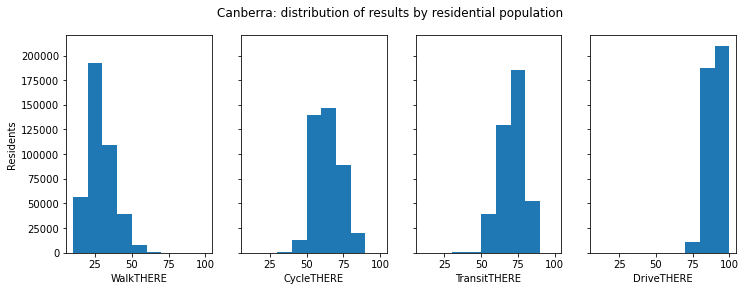

In [175]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(12, 4))
#f.set_figwidth(4)
bins=[10,20,30,40,50,60,70,80,90,100]
ax1.hist(meshblocks_w['THERE_Index_walking'], weights = meshblocks_w['Persons'], label='WalkTHERE',bins=bins)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')
ax2.hist(meshblocks_w['THERE_Index_cycle'], weights = meshblocks_w['Persons'],bins=bins)
ax2.set_xlabel('CycleTHERE')
ax3.hist(meshblocks_w['THERE_Index_left'], weights = meshblocks_w['Persons'],bins=bins)
ax3.set_xlabel('TransitTHERE')
ax4.hist(meshblocks_w['THERE_Index_drive'], weights = meshblocks_w['Persons'],bins=bins)
ax4.set_xlabel('DriveTHERE')
fig.suptitle('Canberra: distribution of results by residential population')

### Public transport

In [73]:
import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

In [14]:
bbox = place_gdf.to_crs("EPSG:4326").bounds
bbox_points = (bbox['minx'][0], bbox['miny'][0], bbox['maxx'][0], bbox['maxy'][0])

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=(folder + "Canberra Data\GTFS"), 
                                     validation=True, 
                                     verbose=True, 
                                     bbox=bbox_points, 
                                     remove_stops_outsidebbox=True, 
                                     append_definitions=True)

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 1.08 seconds
--------------------------------
Processing GTFS feed: GTFS
The unique agency id: transport_canberra was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.06 seconds
Unique GTFS feed id operation complete. Took 0.02 seconds
No GTFS feed stops were found to be outside the bounding box coordinates
GTFS GTFS feed stops: coordinates are in southeast hemisphere. Latitude = South (-90); Longitude = East (90).
Appended route type to stops
Appended route type to stop_times
--------------------------------
Added descriptive definitions to stops, routes, stop_times, and trips tables
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 4.12 seconds
1 GTFS feed file(s) successfully read as dataframes:
     GTFS
    

<AxesSubplot:xlabel='stop_lon', ylabel='stop_lat'>

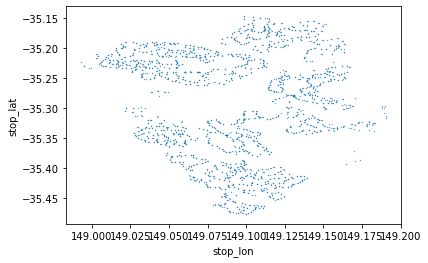

In [17]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

In [18]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
3 service_ids were extracted from calendar
12,818 trip(s) 68.77 percent of 18,640 total trip records were found in calendar for GTFS feed(s): ['gtfs']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
12,818 of 18,640 total trips were extracted representing calendar day: monday. Took 0.09 seconds
There are no departure time records missing from trips following the specified schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 4.25 seconds
Stop times from 07:00:00 to 10:00:00 successfully sel

In [19]:
urbanaccess_net = ua.network.ua_network

In [20]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox_points, remove_lcn=True, network_type='walk')

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](-35.59279603,148.96133881,-35.12442856,149.39928205);>;);out;'}"
Downloaded 78,025.6KB from www.overpass-api.de in 12.52 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 16.80 seconds
Returning OSM data with 539,800 nodes and 81,890 ways...
Edge node pairs completed. Took 251.76 seconds
Returning processed graph with 123,783 nodes and 373,050 edges...
Completed OSM data download and Pandana node and edge table creation in 284.12 seconds
checking for low connectivity nodes...
184 out of 123,783 nodes (0.15 percent of total) were identified as having low connectivity and have been removed.
Completed OSM data download and graph node and edge tab

In [21]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.02 seconds


In [216]:
bbox_points

(148.96133880753274,
 -35.59279602848771,
 149.3992820456541,
 -35.124428561426235)

Figure created. Took 78.36 seconds


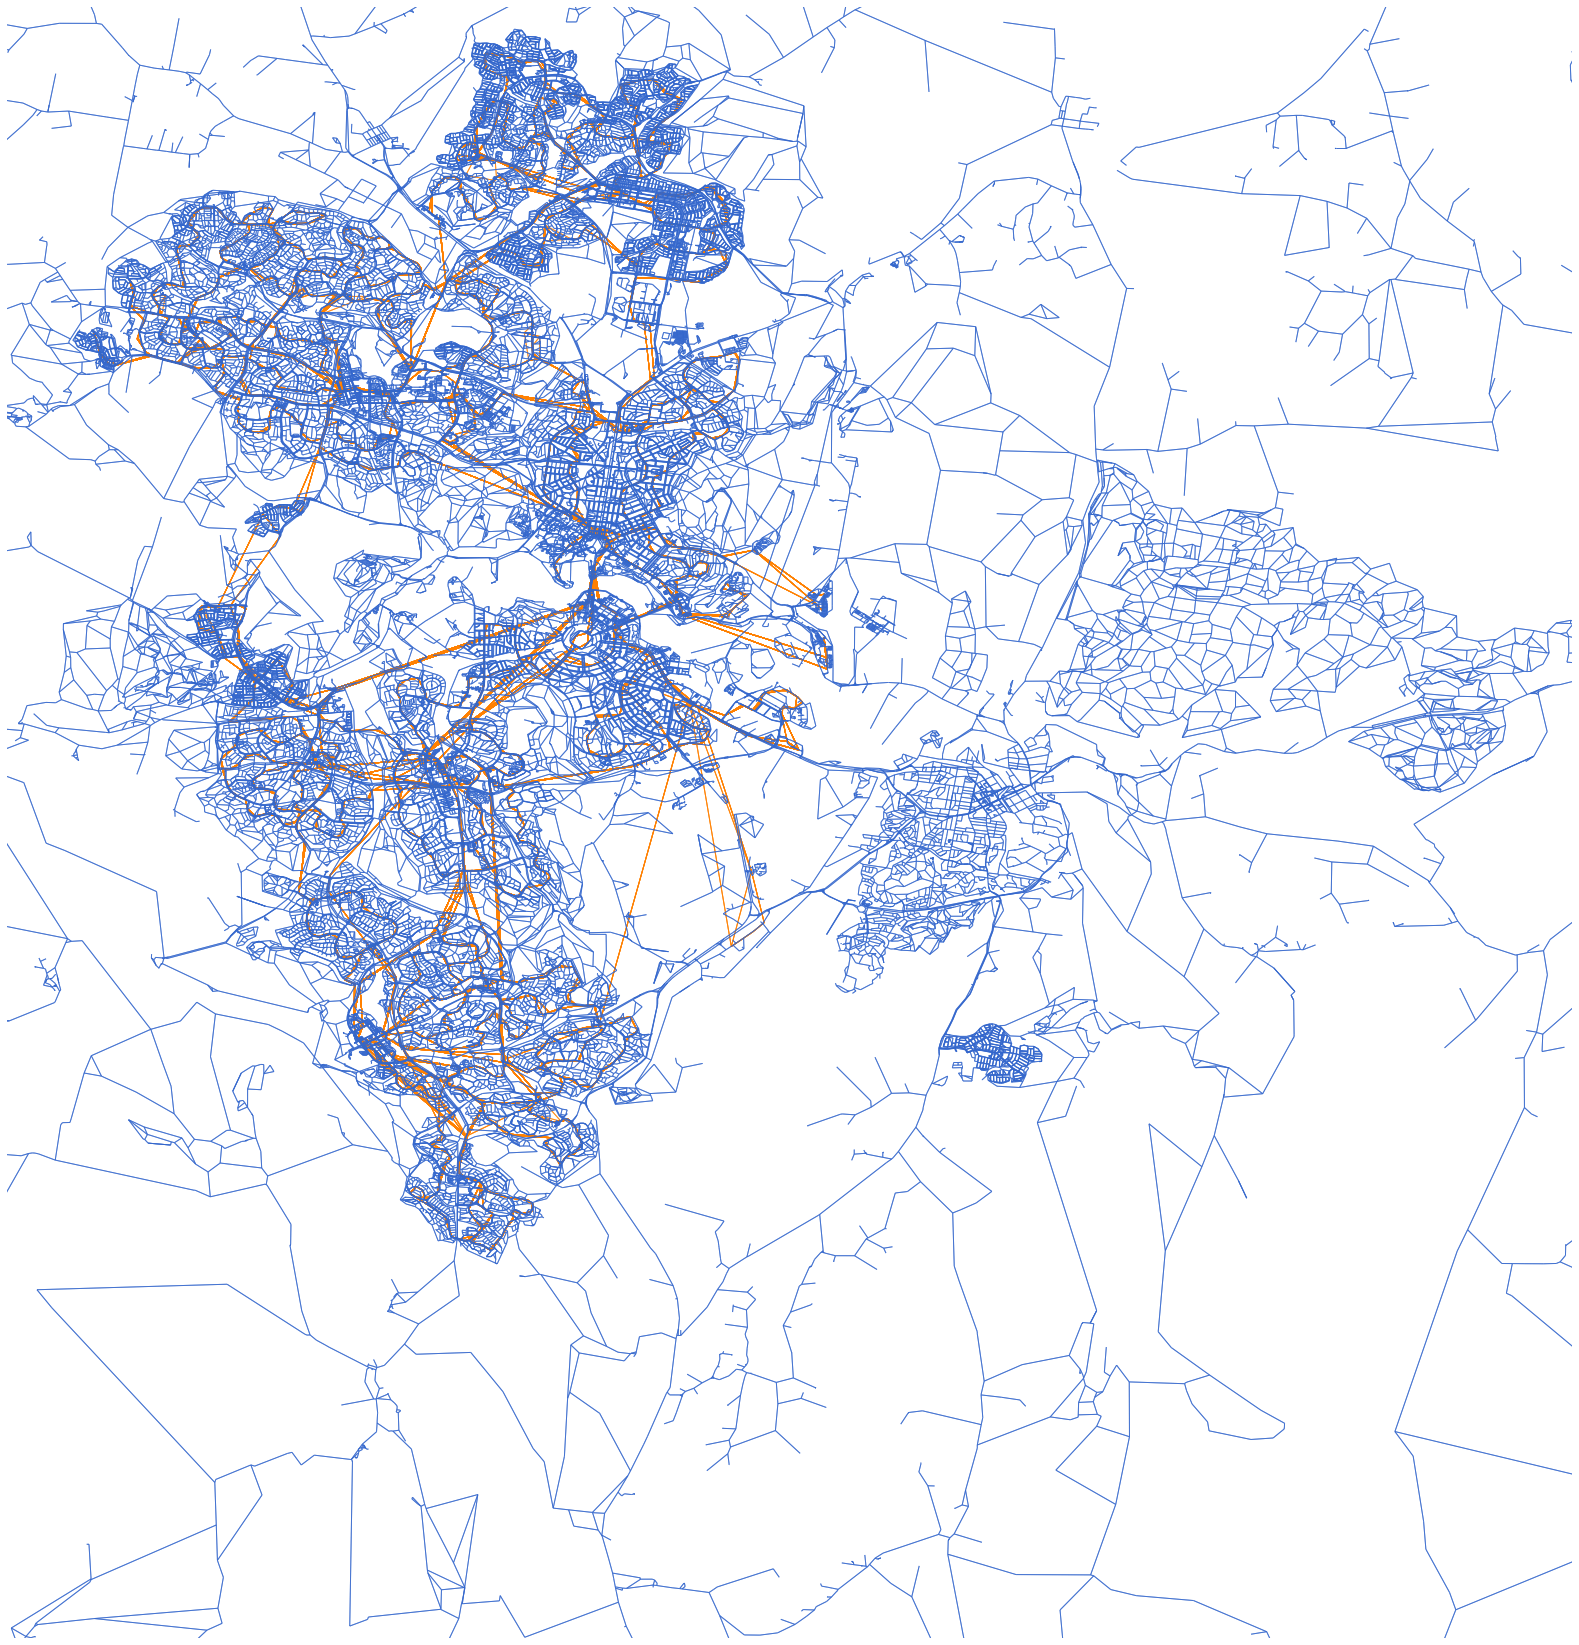

(<Figure size 2019.69x2160 with 1 Axes>, <AxesSubplot:>)

In [224]:
edgecolor = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)
colours = {'transit':(1, 0.5, 0, 1.00), 
           'walk':(0.2, 0.4, 0.8, 1.00), 
           'transit to osm':(1, 0.4, 0.8, 1.00), 'osm to transit':(0, 0.8, 0, 1.00)}
#orange, blue, pink, green
edgecolour = [colours[x] for x in urbanaccess_net.net_edges['net_type']]
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges[(urbanaccess_net.net_edges['net_type']=='transit')|(urbanaccess_net.net_edges['net_type']=='walk')],
                 bbox=bbox_points,
                 #(149.2, -35.3, 149.3, -35.2),
                 fig_height=30, margin=0.02,
                 edge_color=edgecolour, edge_linewidth=1, edge_alpha=0.7,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

In [218]:
urbanaccess_net.net_edges

,weight,unique_agency_id,unique_trip_id,sequence,edge_id,route_type,unique_route_id,net_type,from,to,...,maxspeed,hgv,area,width,est_width,junction,mean,node_id_route,from_int,to_int
0,4.000000,transport_canberra,49176191-2020-COMBNXT-Weekday-08_transport_can...,1.0,49176191-2020-COMBNXT-Weekday-08_transport_can...,3.0,3-10562_transport_canberra,transit,3353_transport_canberra_3-10562_transport_canb...,3467_transport_canberra_3-10562_transport_canb...,...,nan,nan,nan,nan,nan,nan,NaN,nan,1,2
1,1.000000,transport_canberra,49176191-2020-COMBNXT-Weekday-08_transport_can...,2.0,49176191-2020-COMBNXT-Weekday-08_transport_can...,3.0,3-10562_transport_canberra,transit,3467_transport_canberra_3-10562_transport_canb...,3469_transport_canberra_3-10562_transport_canb...,...,nan,nan,nan,nan,nan,nan,NaN,nan,2,3
2,6.000000,transport_canberra,49176191-2020-COMBNXT-Weekday-08_transport_can...,3.0,49176191-2020-COMBNXT-Weekday-08_transport_can...,3.0,3-10562_transport_canberra,transit,3469_transport_canberra_3-10562_transport_canb...,3070_transport_canberra_3-10562_transport_canb...,...,nan,nan,nan,nan,nan,nan,NaN,nan,3,4
3,1.000000,transport_canberra,49176191-2020-COMBNXT-Weekday-08_transport_can...,4.0,49176191-2020-COMBNXT-Weekday-08_transport_can...,3.0,3-10562_transport_canberra,transit,3070_transport_canberra_3-10562_transport_canb...,3072_transport_canberra_3-10562_transport_canb...,...,nan,nan,nan,nan,nan,nan,NaN,nan,4,5
4,0.000000,transport_canberra,49176191-2020-COMBNXT-Weekday-08_transport_can...,5.0,49176191-2020-COMBNXT-Weekday-08_transport_can...,3.0,3-10562_transport_canberra,transit,3072_transport_canberra_3-10562_transport_canb...,3029_transport_canberra_3-10562_transport_canb...,...,nan,nan,nan,nan,nan,nan,NaN,nan,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544739,0.108083,nan,nan,NaN,nan,NaN,nan,transit to osm,5169_transport_canberra_28-10567_transport_can...,4822769801,...,nan,nan,nan,nan,nan,nan,NaN,nan,7270,69653
544740,0.108083,nan,nan,NaN,nan,NaN,nan,osm to transit,4822769801,5169_transport_canberra_28-10567_transport_can...,...,nan,nan,nan,nan,nan,nan,NaN,5169_transport_canberra_28-10567_transport_can...,69653,7270
544741,0.056281,nan,nan,NaN,nan,NaN,nan,transit to osm,4809_transport_canberra_903-10567_transport_ca...,4269669202,...,nan,nan,nan,nan,nan,nan,NaN,nan,7271,65732
544742,7.556281,nan,nan,NaN,nan,NaN,nan,osm to transit,4269669202,4809_transport_canberra_903-10567_transport_ca...,...,nan,nan,nan,nan,nan,nan,15.0,4809_transport_canberra_903-10567_transport_ca...,65732,7271


In [23]:
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['07:00:00','10:00:00'])

Stop times from 07:00:00 to 10:00:00 successfully selected 83,877 records out of 430,092 total records (19.50 percent of total). Took 0.06 seconds
Starting route stop headway calculation for 7,271 route stops...
Route stop headway calculation complete. Took 31.75 seconds
headway calculation complete. Took 32.98 seconds


In [24]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 2,433 nodes and 80,880 edges;
     OSM: 123,599 nodes and 372,716 edges
routes successfully joined to transit nodes. Took 0.30 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 7.68 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.13 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 9.75 seconds
Network edge and node network integration completed successfully resulting in a total of 130,870 nodes and 544,744 edges:
     Transit: 7,271 nodes 80,880 edges;
     OSM: 123,599 nodes 372,716 edges; and
     OSM/Transit connector: 91,148 edges.


In [25]:
ua.network.save_network(urbanaccess_network=urbanaccess_net,
                        filename='Canberra_integrated_net.h5',
                        overwrite_key = True)

New Canberra_integrated_net.h5 hdf5 store created in dir: data
edges saved in data/Canberra_integrated_net.h5 hdf5 store.
Using existing data/Canberra_integrated_net.h5 hdf5 store.
nodes saved in data/Canberra_integrated_net.h5 hdf5 store.


In [74]:
urbanaccess_net = ua.network.load_network(dir='data', filename='Canberra_integrated_net.h5')

Successfully read store: data/Canberra_integrated_net.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/Canberra_integrated_net.h5 with the following keys: ['/edges', '/nodes']


In [75]:
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)

In [76]:
wgs_pois = pois.to_crs("EPSG:4326")
transit_max_time = 60
# need to change the distance/time decay
transit_gammas = poi_gammas.copy()
transit_gammas = transit_gammas.replace(to_replace=0.001, value=0.025)
transit_gammas

category
employment    0.025
education     0.025
shopping      0.025
errands       0.025
recreation    0.025
Name: distance_constant, dtype: float64

In [250]:
# check some individual paths
category = 'education'
relevant_pois = gpd.GeoDataFrame()
for key in poi_dictionary[category]:
                relevant_pois = pd.concat([relevant_pois, wgs_pois.loc[(wgs_pois[key].isin(poi_dictionary[category][key]))]])
relevant_pois = relevant_pois.reset_index()
x, y = (relevant_pois['geometry'].x, relevant_pois['geometry'].y)
transit_ped_net.set_pois(category, transit_max_time, 20, x, y)
access = transit_ped_net.nearest_pois(
                    distance=transit_max_time, category=category, num_pois=20, include_poi_ids = True)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [230]:
transit_ped_net.nodes_df

,x,y
id_int,,
1,149.189463,-35.307607
2,149.190329,-35.316348
3,149.190282,-35.313168
4,149.150943,-35.300714
5,149.150857,-35.298779
...,...,...
130866,149.163879,-35.158333
130867,149.154574,-35.165616
130868,149.052841,-35.339951


In [252]:
access.poi1

id_int
1         129.0
2         129.0
3         129.0
4         130.0
5         131.0
          ...  
130866    262.0
130867    262.0
130868     91.0
130869     91.0
130870     91.0
Name: poi1, Length: 130870, dtype: float64

In [258]:
relevant_pois.loc[129][5:10]

shop                                NaN
website                             NaN
amenity                       childcare
addr:housenumber                     37
addr:street         Brindabella Circuit
Name: 129, dtype: object

In [280]:
meshblocks_pt.columns[140:145]

Index(['education2', 'education3', 'education4', 'education5',
       'education_14.3'],
      dtype='object')

In [290]:
meshblocks_pt.iloc[:,33:39], meshblocks_pt.iloc[:,139:145], meshblocks_pt.iloc[:,69:75], meshblocks_pt.iloc[:,104:110]

(      education1_left  education2_left  education3_left  education4_left  \
 0                85.0           2087.0           2198.0           2400.0   
 1              1980.0           2400.0           2400.0           2400.0   
 2              2017.0           2400.0           2400.0           2400.0   
 3              1929.0           2400.0           2400.0           2400.0   
 4              2030.0           2080.0           2400.0           2400.0   
 ...               ...              ...              ...              ...   
 6366           1291.0           2400.0           2400.0           2400.0   
 6367           1496.0           2400.0           2400.0           2400.0   
 6368           1685.0           2400.0           2400.0           2400.0   
 6369           1596.0           2400.0           2400.0           2400.0   
 6370           1907.0           2400.0           2400.0           2400.0   
 
       education5_left  education_14.3_left  
 0              2400.0      

In [18]:
meshblocks_pt.filter(like='Jobs', axis=1)

,Jobs_left,Jobs_cycle,Jobs_drive,Jobs
0,13.0,8078.0,14615.0,7268.0
1,107.0,9009.0,16885.0,17203.0
2,104.0,9082.0,16995.0,17384.0
3,114.0,9324.0,16995.0,18095.0
4,154.0,8836.0,17262.0,18750.0
...,...,...,...,...
6569,89.0,4459.0,9296.0,9833.0
6570,72.0,4148.0,8998.0,9228.0
6571,60.0,3993.0,8885.0,7958.0
6572,65.0,4024.0,8884.0,9407.0


In [24]:
sum(employment_centrs.Jobs)

215451.9999999999

In [19]:
meshblocks_pt.filter(like='employment_', axis=1)

,employment_31.9_left,employment_31.9_cycle,employment_31.9_drive,employment_31.9
0,0.007,3.987,6.846,3.611
1,0.057,4.414,7.769,7.896
2,0.055,4.447,7.813,7.967
3,0.060,4.556,7.813,8.247
4,0.081,4.335,7.919,8.502
...,...,...,...,...
6569,0.047,2.267,4.544,4.786
6570,0.038,2.114,4.409,4.513
6571,0.031,2.038,4.358,3.932
6572,0.034,2.053,4.357,4.594


In [15]:
np.mean(meshblocks_pt['THERE_Index_cycle'] - meshblocks_pt['THERE_Index_drive'])

-8.517317158503195

In [77]:
results = there_index(transit_ped_net, wgs_pois, poi_dictionary, poi_weights, transit_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=transit_max_time)

Finished category: employment
Maximum score: 27.850475134978048 out of 31.9
Finished category: education
Maximum score: 13.023078150013248 out of 14.3
Finished category: shopping
Maximum score: 21.431699728934856 out of 21.6
Finished category: errands
Maximum score: 8.843441324413595 out of 8.9
Finished category: recreation
Maximum score: 23.199603350138638 out of 23.3


In [78]:
max(results.THERE_Index), np.mean(results.THERE_Index)

(91.58456087873022, 66.18569590155263)

In [79]:
small_pt_results = gpd.GeoDataFrame(result_rounding(results), geometry = gpd.GeoSeries.from_xy(results.x, results.y, crs="EPSG:4326"))

In [80]:
meshblocks_pt = meshblocks_d.sjoin_nearest(small_pt_results.to_crs(proj_crs), how='left', rsuffix = 'transit')